# Text Classfiication

---

### Index
* [Dataset](#Dataset "Go to Dataset")
* [Feature Extarction](#Feature-Extarction "Go To Feature Extarction")
* [Model](#Model "Go to Model")
* [Final Model](#Final-Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

### Dataset

In [2]:
df = pd.read_csv("../Src_Parsed/pubmed_parsed_class.csv").dropna(subset=['AB'])
df.head()

,PMID,TI,AB,TY
0,28244479,Cancer and cure: A critical analysis.,Cancer is one of the most dreaded diseases of ...,CANCER
1,29949179,Tumor microenvironment: recent advances in var...,This is a review regarding different types of ...,CANCER
2,26667886,Global Cancer Incidence and Mortality Rates an...,There are limited published data on recent can...,CANCER
3,30713326,Recent Updates on the Relationship between Can...,Autoimmune pancreatitis (AIP) is now considere...,CANCER
4,31761807,What Is Cancer?,This essay focuses on themes in Explaining Can...,CANCER


In [3]:
df = df.drop_duplicates(subset=['PMID'],keep="last")
df.shape

(38754, 4)

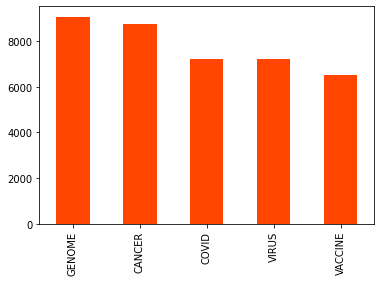

In [4]:
df['TY'].value_counts().plot.bar(color='orangered')
plt.show()

In [5]:
df['NTY'] = df['TY'].astype('category').cat.codes
class_names = df['TY'].astype('category').cat.categories

In [6]:
X,Y = df['AB'].values,df['NTY'].values

---
### Feature Extarction

* Steamming or Lemmantization - `For fast process use stem else go with lemma`
* stop words
* characters
* Bag of Words
* TFIDF

In [7]:
n_grams = (1,1)

In [8]:
# Tokenize
from nltk.tokenize import word_tokenize

# Stemming
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language='english')

# Lemmatization
from nltk.stem import WordNetLemmatizer
wordnet = WordNetLemmatizer()

# Stop Words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#### Normalize

In [9]:
def normalize_sentence(sentence,action="STEM"):
    sen = sentence.lower()
    sen = re.sub(r'[^a-z\s]','',sen)
    tokens = word_tokenize(sen)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [snowball.stem(token) if action == "STEM" else wordnet.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

#### Bag of Words


`fit` - Intialize Vacobaullary\
`transform` - get Sparse Matrix

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=n_grams)

def implemnt_bow(x,isfit):
    if isfit:
        bow.fit(x)
    arr = bow.transform(x)
    return arr

#### TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=n_grams)

def implement_tfidf(x,isfit):
    if isfit:
        tfidf.fit(x)
    arr = tfidf.transform(x)
    return arr

In [12]:
def get_features(x,feat_model="BOW",pre_action="STEM",isfit=False):
    # Normalize
    print(f'\r ⏳ Normalizing',end="")
    normed = [normalize_sentence(i,pre_action) for i in x]
    print(f'\r ✅ Normalized      ')
    
    # Featurize
    print(f'\r ⏳ {feat_model}ing         ',end="")
    arr = implemnt_bow(normed,isfit) if feat_model == "BOW" else implement_tfidf(normed,isfit)
    print(f'\r ✅ {feat_model}          ')
    return arr

In [13]:
arr = get_features(X,feat_model="TFIDF",pre_action="LEMM",isfit=True)

 ✅ Normalized      
 ✅ TFIDF            


---

### Model

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(arr,Y,test_size=0.3,shuffle=True)

#### GridSearchCV

For best hyperparameters

In [15]:
from sklearn.model_selection import GridSearchCV

def get_best_hyper_params(model,parameters,x,y):
    # Model
    gs = GridSearchCV(
        estimator = model,
        param_grid = parameters,
        scoring = "r2",
        refit = "r2",
        cv=2,
        verbose = 10
    )
    
    gs.fit(x,y)
    
    return gs.best_params_,gs.best_score_,gs.best_estimator_

#### StratifiedKFold 

For 5-Fold Training

In [16]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_kfold(k,model,x,y):
    acc_scores = []
    
    skf = StratifiedKFold(n_splits=k,shuffle=True)
    count = 1
    
    for train,test in skf.split(x,y):
        print(f'\r⏳ Fold {count}',end="")
        model.fit(x[train],y[train])
        score = model.score(x[test],y[test])
        acc_scores.append(score)
        print(f'\r✅ Fold {count} - {round(score*100,2)} %')
        count = count + 1
    
    return acc_scores

----

#### Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB

mnbmodel = MultinomialNB()

In [18]:
# Train on 5-Fold
navie_byes = cross_validate_kfold(5,mnbmodel,x_train,y_train)
print(f'Mean Score of Naive Bayes = {(sum(navie_byes) / len(navie_byes))}')

✅ Fold 1 - 93.66 %
✅ Fold 2 - 93.22 %
✅ Fold 3 - 93.84 %
✅ Fold 4 - 93.22 %
✅ Fold 5 - 93.46 %
Mean Score of Naive Bayes = 0.9347882477438378


####  K-Nearest Neighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=len(class_names))

In [20]:
# Train on 5-Fold
knn_scores = cross_validate_kfold(5,knn,x_train,y_train)
print(f'Mean Score of K-Nearest Neighbors = {(sum(knn_scores) / len(knn_scores))}')

✅ Fold 1 - 89.64 %
✅ Fold 2 - 89.55 %
✅ Fold 3 - 89.27 %
✅ Fold 4 - 89.68 %
✅ Fold 5 - 89.84 %
Mean Score of K-Nearest Neighbors = 0.8959708045067188


#### Decision tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()

In [22]:
# Train on 5-Fold
desicion_tree = cross_validate_kfold(5,dtmodel,x_train,y_train)
print(f'Mean Score of Descision Tree = {sum(desicion_tree) / len(desicion_tree)}')

✅ Fold 1 - 95.39 %
✅ Fold 2 - 95.08 %
✅ Fold 3 - 95.28 %
✅ Fold 4 - 95.21 %
✅ Fold 5 - 95.58 %
Mean Score of Descision Tree = 0.9530726371235272


#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_hyper_parms = { 
    "n_estimators":[10,20,30,40,50] ### For best Hyper Parametres
}

In [ ]:
# [✔️ Exceuted] For best Hyper Parametres
# This cell takes nearly a 1.5 hours time for excution as it has to run the brute force on parameters,we have already excuted found the best hyper parametres

rf_opt_parms,rf_best_score,rfmodel = get_best_hyper_params(RandomForestClassifier(),rf_hyper_parms,x_train,y_train)
print(f'Top Score - {rf_best_score}')
print(f'Best Parametres \n {rf_opt_parms}')

In [24]:
# No need to run whole best hyparn_estimators

rfmodel = RandomForestClassifier(n_estimators=50)

In [25]:
# Random Forest
random_forest = cross_validate_kfold(5,rfmodel,x_train,y_train)
print(f'Mean Score of Random Forest = {sum(random_forest) / len(random_forest)}')

✅ Fold 1 - 94.75 %
✅ Fold 2 - 94.99 %
✅ Fold 3 - 95.39 %
✅ Fold 4 - 95.13 %
✅ Fold 5 - 95.23 %
Mean Score of Random Forest = 0.9509715264106428


#### SVM

In [26]:
from sklearn.svm import SVC

svm_hyper_parms = {
    "C": [0.1,1,10,100,1000],
    "gamma": [1,0.1,0.01,0.001,0.0001],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [0.1,1,3,5]
}

In [28]:
# [✔️ Exceuted] For best Hyper Parametres
# # This cell takes nearly a 5-7 hours time for excution as it has to run the brute force on parameters,we have already excuted found the best hyper parametres

svm_opt_parms,svm_best_score,svmmodel = get_best_hyper_params(SVC(),svm_hyper_parms,x_train,y_train)
print(f'Top Score - {svm_best_score}')
print(f'Best Parametres \n {svm_opt_parms}')

In [27]:
# No need to run whole best hyparms
svmmodel = SVC(
    C=10,
    gamma=0.1,
    kernel='rbf',
    degree=3
)

In [28]:
# Train on 5-Fold
svm_scores = cross_validate_kfold(5,svmmodel,x_train,y_train)
print(f'Mean Score of SVM(Support Vector Machine) = {sum(svm_scores) / len(svm_scores)}')

✅ Fold 1 - 97.35 %
✅ Fold 2 - 97.6 %
✅ Fold 3 - 97.25 %
✅ Fold 4 - 97.24 %
✅ Fold 5 - 97.12 %
Mean Score of SVM(Support Vector Machine) = 0.9731262856259585


---

||Model|Accuracy|
|:-|:-|:-|
|❌|Naive Bayes|`0.9347882477438378`|
|❌|K-Nearest Neighbors|`0.8959708045067188`|
|❌|Decision tree|`0.9530726371235272`|
|❌|Random Forest|`0.9509715264106428`|
|✅|Support Vector Machine(SVM)|`0.9731262856259585`|


As the SVM model has the highest accuracy score among the other model we are using **SVM** as our final model

### Final Model - SVM

TF-IDF
LEMMATION


In [29]:
%%time
# Refit Model on Compltet Train data

svmmodel.fit(x_train,y_train)

Wall time: 2min 51s


SVC(C=10, gamma=0.1)

In [14]:
import pickle

Save Model
with open('../Trained Models/svm.pkl','wb') as f:
    pickle.dump(svmmodel,f)


# Load Model
# svmmodel = None
# with open('../Trained Models/svm.pkl','rb') as f:
#     svmmodel = pickle.load(f)

In [15]:
svmmodel

SVC(C=10, gamma=0.1)

In [18]:
%%time
# predictions on test data

predicted_y = svmmodel.predict(x_test)

In [19]:
from sklearn.metrics import classification_report

report_data = classification_report(y_test,predicted_y,output_dict=True,target_names=class_names)
report_data_str = classification_report(y_test,predicted_y,target_names=class_names)
print(report_data_str)

              precision    recall  f1-score   support

      CANCER       0.99      1.00      1.00      2640
       COVID       0.99      0.98      0.99      2128
      GENOME       0.99      0.99      0.99      2763
     VACCINE       0.98      0.99      0.99      1960
       VIRUS       0.99      0.99      0.99      2136

    accuracy                           0.99     11627
   macro avg       0.99      0.99      0.99     11627
weighted avg       0.99      0.99      0.99     11627



In [20]:
def get_f1_recall_precision(report,classes_of_data):
    p,f,r = [],[],[]
    for c in classes_of_data:
        p.append(report[c]['precision'])
        f.append(report[c]['f1-score'])
        r.append(report[c]['recall'])
        
    return f,r,p

In [21]:
avg_f1_score,avg_recall,avg_precision = get_f1_recall_precision(report_data,class_names)
print(f"F1 Score  = {sum(avg_f1_score) / len(avg_f1_score)}")
print(f"Recall    = {sum(avg_recall) / len(avg_recall)}")
print(f"Precision = {sum(avg_precision) / len(avg_precision)}")
print(f"Accuracy  = {report_data['accuracy']}")

F1 Score  = 0.9899644082799984
Recall    = 0.9899937223398115
Precision = 0.9899385471154896
Accuracy  = 0.9904532553539176


#### Predict Abstracts Class

In [22]:
def predict_abstract_class(model,abstracts):
    arr = get_features(abstracts,feat_model="TFIDF",pre_action="LEMM",isfit=False) # We need to make sure this is same as trainging our model
    print('\r ⏳ Predicting...',end="")
    predicted_labels = model.predict(arr)
    print(f'\r ✅ Predicted.')
    return [class_names[i] for i in predicted_labels]

In [25]:
%%time

predict_abstract_class(svmmodel,[
    "This essay focuses on themes in Explaining Cancer: Finding Order in Disorder (2018) by Anya Plutynski, a monograph that has important things to say about both the peculiarities of cancers and our theories about them. Cancer's agents of destruction are human cells that have been recruited and to some extent transformed into pathological organisms or the building blocks of tumors. Cancers both undermine and exploit mechanisms of multicellular organization, and understanding them gives rise to difficult philosophical problems. In addition to sketching Plutynski's discussion of these problems, this essay defends Christopher Boorse's account of disease from Plutynski's criticisms, and it expresses some qualms about her treatment of scientific explanation.",
    "In the fields of molecular biology and genetics, a genome is all genetic information of an organism. It consists of nucleotide sequences of DNA. The genome includes both the genes and the noncoding DNA, as well as mitochondrial DNA and chloroplast DNA. The study of the genome is called genomics",
    "submicroscopic infectious agent that replicates only inside the living cells of an organism. Viruses infect all life forms, from animals and plants to microorganisms, including bacteria and archaea"
])

 ✅ Normalized      
 ✅ TFIDF            
 ✅ Predicted....
Wall time: 238 ms


['CANCER', 'GENOME', 'VIRUS']